# Simulation Analysis Notebook

This Jupyter Notebook is designed to introduce a user to the PyGkyl library (unofficial naming). 
It includes many different examples of diagnostic tools that can be used to analyze Gkeyll GK simulation data. 

Antoine C.D. Hoffmann (@antoinehoff) -- Jan 13, 2025

## Table of Contents
1. [Prologue](#prologue)<br>
    1.1 [Setup and Imports](#setup_imports)<br>
    1.2 [Simulation Data Setup](#data_setup)<br>
    1.3 [Simulation Class Initialization](#simulation_class)<br>
    1.4 [Source Profiles and Input Power](#sources)<br>
    1.5 [Time Frame and normalization](#time_frames)<br>

2. [Simulation Data Analysis](sim_analysis)<br>
    2.1 [1D Profile Relaxation](#1d_profile)<br>
    2.2 [Space-Time Diagrams](#space_time)<br>
    2.3 [Two-Dimensional Cut](#2d_cut)<br>
    2.4 [Space-Time Fluctuation](#st_fluct_plot)<br>
    2.5 [Two-Dimensional Fluctuation](#2d_fluct_plot)<br>
    2.6 [Time-Averaged Profile](#time_averaged_profile)<br>
    2.7 [Movie Generator](#movie_generator)<br>
    2.8 [Flux Surface Time-Average Profiles](#fs_time_averaged_profile)<br>
    2.9 [Volume Integral Quantities](#volume_integrals)<br>
    2.10 [Grad B Loss](#gradb_loss)<br>
    2.11 [Phase Space Analysis](#dist_funct)<br>
    2.12 [DG Representation](#dg_rep)<br>
    2.13 [Poloidal projection plot](#pol_plot)<br>

## 1. Prologue <a id="prologue"></a>
This section imports necessary libraries and custom routines required for the analysis. It also builds a Simulation class instance that will deliver helpful data to the plotting routine. Finally, it looks for the available simulation frames.

### 1.1 Simulation Data Path <a id="data_setup"></a>
Set up the path to the simulation data and its file prefix.

In [1]:
simdir = 'sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'

### 1.2 Import PyGkyl <a id="setup_import"></a>
Install and import the pygkyl library. (if needed you can also install postgkyl here)

In [2]:
import sys

install_pgkyl = False
if install_pgkyl:
    print("pull postgkyl repository")
    !git -C ~/postgkyl/ pull
    # install postgkyl (required by pygkyl)
    !{sys.executable} -m pip install ~/postgkyl/ > ~/personal_gkyl_scripts/pygkyl/postgkyl_install.log

install_pygkyl = True
if install_pygkyl:
    print("pull personal_gkyl_scripts repository")
    !git -C ~/personal_gkyl_scripts/ pull
    # Clean the pygkyl build and egg-info directories
    !rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
    !rm -rf ~/personal_gkyl_scripts/pygkyl/build
    # Install the pygkyl package
    !{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/pygkyl_install.log
# Import the pygkyl package
import pygkyl

pull personal_gkyl_scripts repository
Already up to date.


### 1.3 Simulation Class Initialization <a id="simulation_class"></a>
Initialize the `Simulation` class (see /python_utilities/classes/simulation.py) and set physical and geometric parameters.

The simulation class is made to contain every parameter and information about the simulation we want to analyze. It is meant to store geometry, metric, where the data are located and how they were generated. It will be used by all plot and post processing routines.

For now we pass many simulation parameters manually as not all simulation parameters are stored in the output file metadata. The parameters of some simulation configurations are stored in `pygkyl/configs/simulation_configs.py`, we load them from here to make the code sparser.

In [3]:
simulation = pygkyl.simulation_configs.import_config( 'TCV_PT', simdir, fileprefix)

### 1.4 Source Profiles and Input Power <a id="sources"></a>
The sources were defined in the `import_config`. One can check the source with the following call:

-- Source Informations --
Total input particle: 4.92824e+21 part/s
Grad-B drift loss: 73.233 %
(input particle after grad-B drift: 1.31914e+21 part/s)
Total input power: 396.009 kW
Grad-B drift loss: 87.6007 %
(input power after grad-B drift: 49.1025 kW)


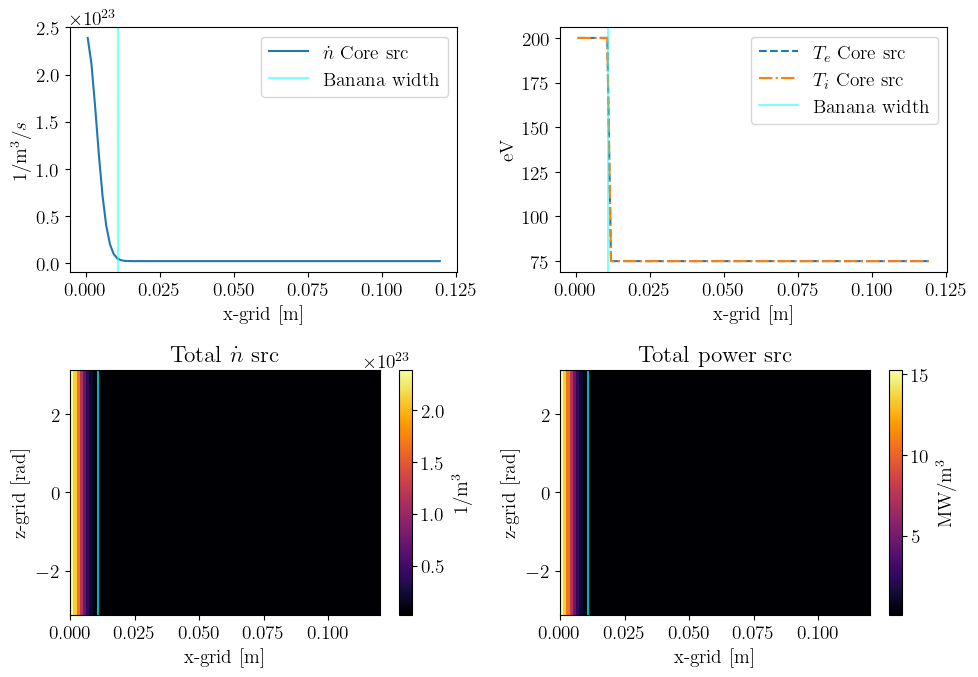

In [4]:
pygkyl.plot_utils.plot_sources_info(simulation, z_const=0, profileORgkyldata='profile')

### 1.5 Time Frame and normalization <a id="time_frames"></a>
Load available time frames and integrated moment diagnostics.

We can set up different units for the plots. These calls will adapt automatically all plotting routine, setting up the axes accordingly.

We also look for all available frames, i.e. we look for all number XX in "[fileprefix]-[fieldname]_XX.gkyl"

In [5]:
simulation.normalization.set('t','mus') # time in micro-seconds
simulation.normalization.set('x','minor radius') # radial coordinate normalized by the minor radius (rho=r/a)
simulation.normalization.set('y','Larmor radius') # binormal in term of reference sound Larmor radius
simulation.normalization.set('z','pi') # parallel angle devided by pi
simulation.normalization.set('fluid velocities','thermal velocity') # fluid velocity moments are normalized by the thermal velocity
simulation.normalization.set('temperatures','eV') # temperatures in electron Volt
simulation.normalization.set('pressures','Pa') # pressures in Pascal
simulation.normalization.set('energies','MJ') # energies in mega Joules
simulation.normalization.set('current','kA') # currents in kA
# For printing the available normalizations
# simulation.normalization.info()

## 2. Simulation Data Analysis <a id="sim_analysis"></a>
We now use the plot routines defined in `python_utilities/tools/plot_utils.py` to generated various plots from the Simulation instance.
You can use `simulation.data_param.help()` to display what fields are available

In [6]:
simulation.data_param.info()

A table of the default quantities and their default units:
| Quantity        | Symbol                         | Units                |
|-----------------|--------------------------------|----------------------|
| phi             | $\phi$                         | V                    |
| b_x             | $b_x$                          |                      |
| b_y             | $b_y$                          |                      |
| b_z             | $b_z$                          |                      |
| Jacobian        | $J$                            | [Jacobian]           |
| Bmag            | $B$                            | T                    |
| g_xx            | $g_{xx}$                       |                      |
| g_xy            | $g_{xy}$                       |                      |
| g_xz            | $g_{xz}$                       |                      |
| g_yy            | $g_{yy}$                       |                      |
| g_yz            | $g_{yz}$ 

Time frames available from 0 to 231


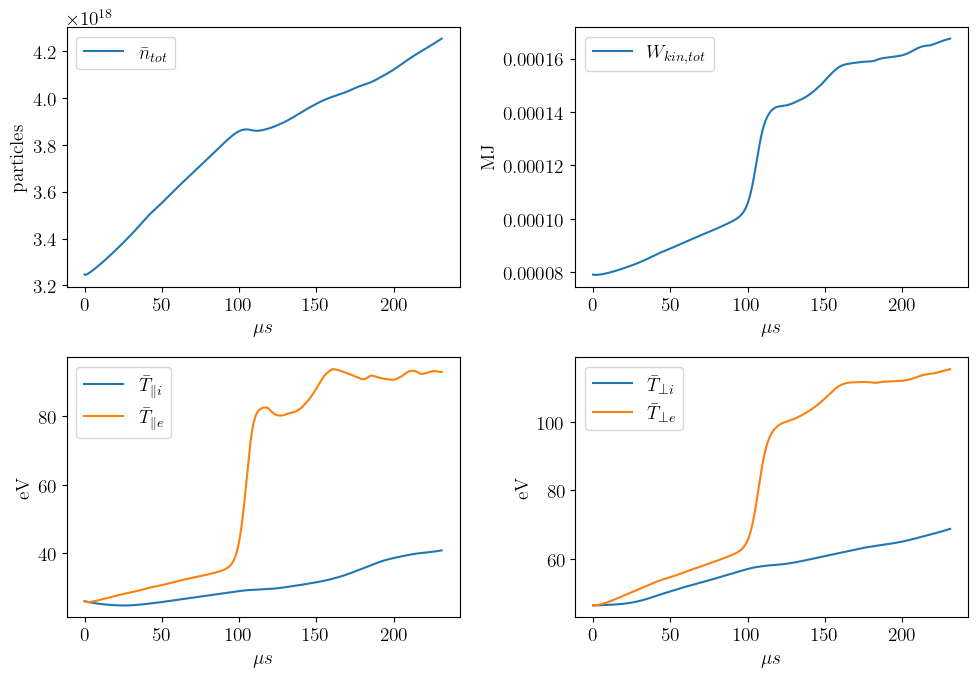

In [7]:
# # Look for frames in the simulation data directory and store them in a list.
fieldname = 'field' #e.g. we check the electrostatic field files.
sim_frames = pygkyl.file_utils.find_available_frames(simulation,fieldname)
print("Time frames available from %g to %g"%(sim_frames[0],sim_frames[-1]))
# # ---- Show the integrated moment time evolution
fieldnames = [['ntot'],['Wtot'],['Tpari','Tpare'],['Tperpi','Tperpe']]
# pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames, ddt=True, plot_src_input=False,twindow=[50,100]);
pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames);

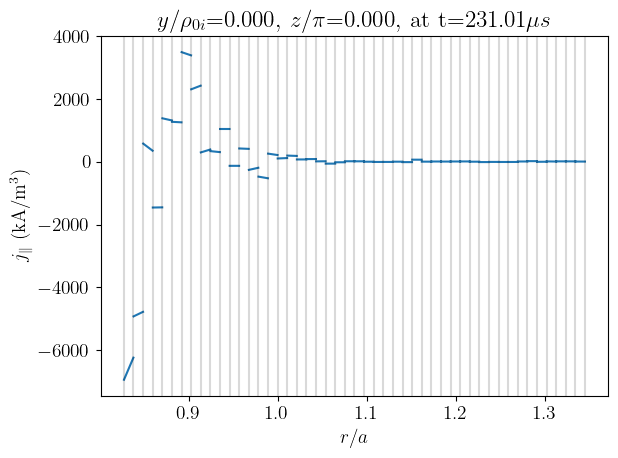

In [8]:
fieldname = 'jpar'
sim_frame = sim_frames[-1]
cutdir = 'x'
cutcoord = [0.0, 0.0]
xlim = []
derivative = ''
pygkyl.plot_utils.plot_DG_representation(simulation, fieldname, sim_frame, cutdir, cutcoord, xlim, derivative = derivative)

### 2.1 Profile relaxation <a id="1d_profile"></a>
Plot 1D cuts for multiple time frames.
- `cut_direction`   The dimension that remains after the cut. Can be 'x','y','z' and 'ky'.
- `cut_coords`      The coordinate of the cut, can be a double corresponding to the physical position (in the normalized units defined above), an integer to select an index or 'avg' to average over the dimension.
- `fieldnames`      The fields we want to plot. An array of char will create a multi plot. (see simulation.display_available_fields())
- `frames`          The frames to plot


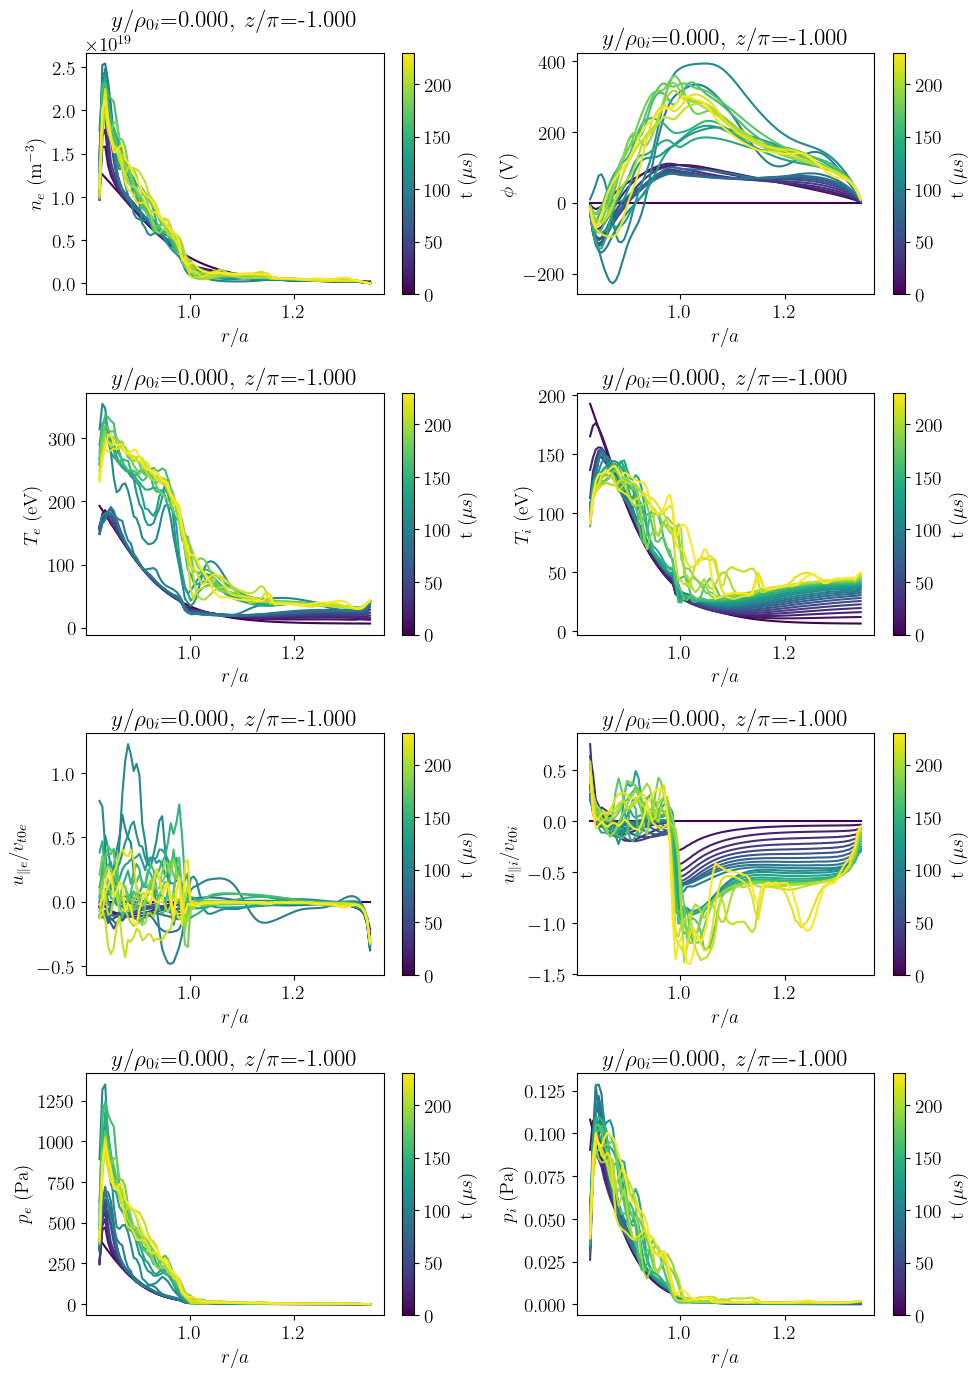

In [9]:
cut_direction='x' 
cut_coords=[0.0,0]
fieldnames = ['ne','phi','Te','Ti','upare','upari','pe','pi']
frames = sim_frames[::10]
pygkyl.plot_utils.plot_1D_time_evolution(simulation,cut_direction,cut_coords,fieldnames,frames,space_time = False)

### 2.2 Space-Time Diagrams <a id="space_time"></a>
Generate space-time diagrams for specified fields. Very useful to see the dynamics without a movie

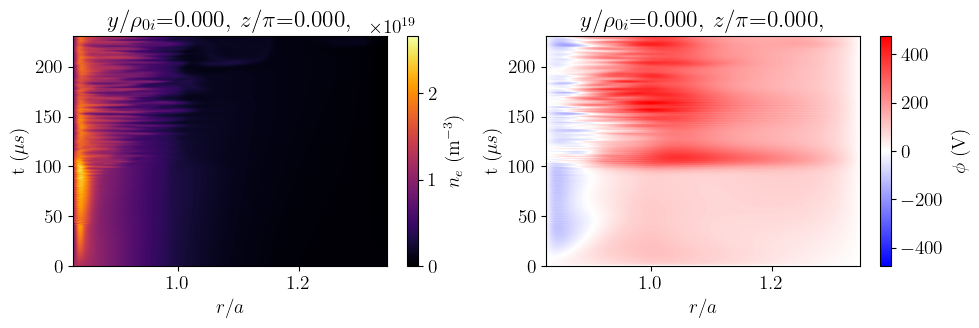

In [10]:
cut_dir = 'x'
cut_coord = [0.0, 0.0]
fieldnames = ['ne', 'phi']
frames = sim_frames[:]
pygkyl.plot_utils.plot_1D_time_evolution(simulation, cut_dir, cut_coord, fieldnames, frames, space_time=True,plot_type='imshow')

### 2.3 Two-dimensional Cut <a id="2d_cut"></a>
Generate a 2D cut plot at a specified plane and time frame.

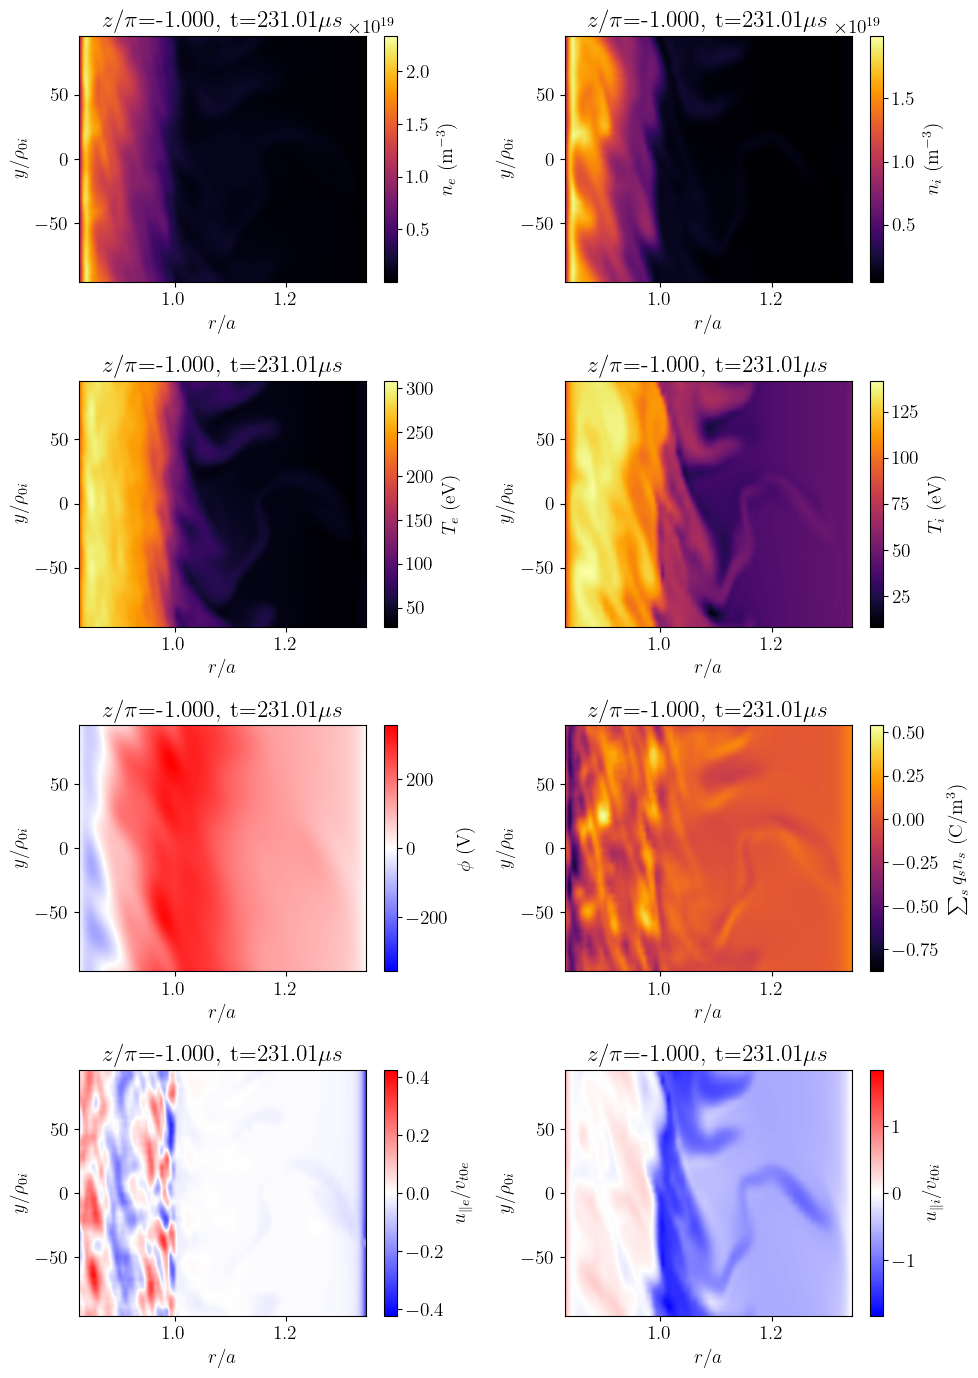

In [11]:
cut_dir = 'xy' # the plane we want to plot
cut_coord = 0 # the coordinate were the plan stands If normalized units are defined, 
# this number is in the normalize units. One can also specify a integer for array index 
# or 'avg' to get an average over the reduced dim.
time_frame = sim_frames[-1] # the time frame
fieldnames = ['ne', 'ni', 'Te', 'Ti', 'phi', 'qdens', 'upare', 'upari'] # the fields to plot, see simulation.display_available_fields() (some may not work in 2x2v)
pygkyl.plot_utils.plot_2D_cut(simulation, cut_dir, cut_coord, time_frame,fieldnames,plot_type='imshow')

### 2.4 Space Time and 2D cut Fluctuation <a id="st_fluct_plot"></a>
Generate a fluctuation plot by averaging over a time window and then substracting this average to each time frame. The average is performed against time only. If `coords` is set to be 'avg', additional averages are performed for both background and fluctuations.

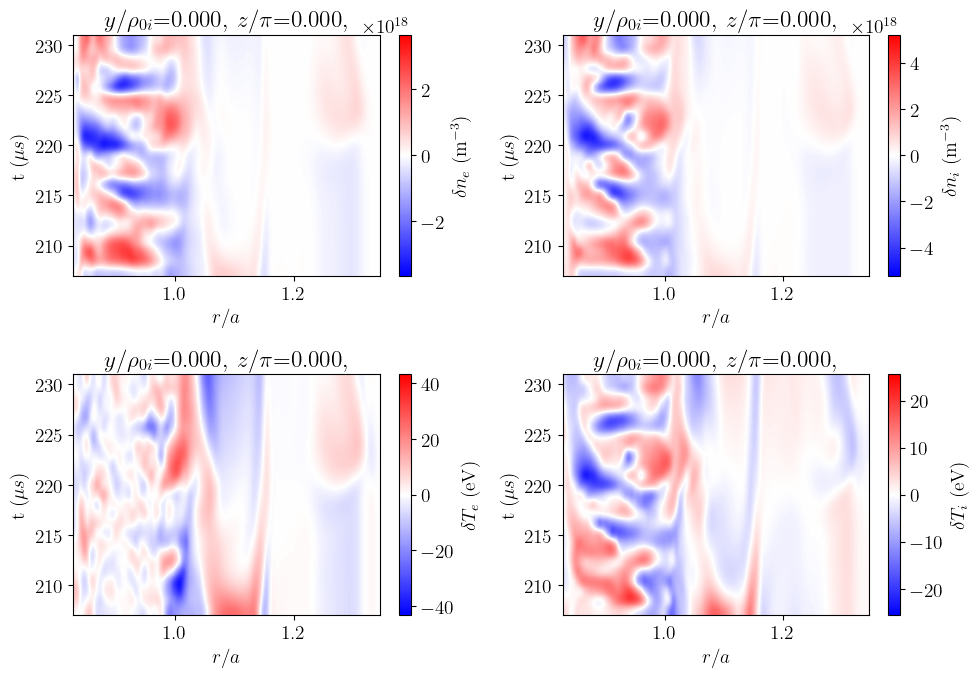

In [12]:
cut_direction='x' 
cut_coords=[0.0,0.0]
fieldnames = ['ne','ni','Te','Ti']
frames = sim_frames[-25:]
pygkyl.plot_utils.plot_1D_time_evolution(
    simulation,cut_direction,cut_coords,fieldnames,frames,
    space_time = True, fluctuation = True,plot_type='imshow')

### 2.5 Two-Dimensional Fluctuation <a id="2d_fluct_plot"></a>
Display the fluctuation of a field on a 2D plane

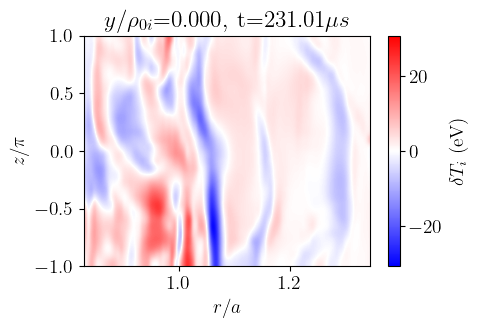

In [13]:
cplane='xz' 
ccoord = 0.0
frames = sim_frames[-25:]
fieldnames = ['Ti']
pygkyl.plot_utils.plot_2D_cut(
    simulation, cplane, ccoord, frames, fieldnames,
    time_average = False,fluctuation = True,plot_type='imshow')

### 2.6 Time-Averaged Profile  <a id="time_averaged_profile"></a>
Here we show the ExB shear averaged over time of the last 50 frames. We generate also error bars that are related to the standard deviation.

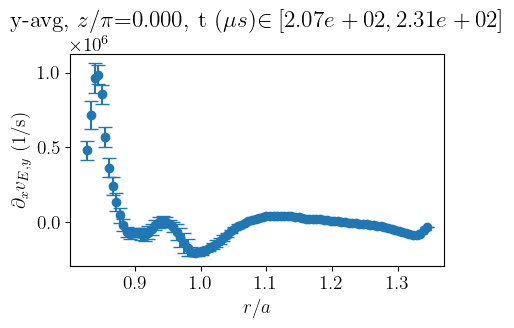

In [14]:
cdirection='x'
ccoords=['avg',0.0]
fieldnames = ['sExBy_x']
time_frames = sim_frames[-25:]
pygkyl.plot_utils.plot_1D(
    simulation,cdirection,ccoords,fieldnames,
    time_frames, errorbar = True,)

### 2.7 Movie Generator <a id="movie_generator"></a>
Create a first movie of 2D cuts over time and a second of the fluctuations over the last 25 frames

In [15]:
cut_dir = 'xz'
cut_coord = 0.0
time_frames = sim_frames[-25:]
fieldnames = ['Ti']
movieprefix = 'gallery/example_movie'
pygkyl.plot_utils.make_2D_movie(simulation, cut_dir=cut_dir, cut_coord=cut_coord, time_frames=time_frames, fieldnames=fieldnames, movieprefix=movieprefix, plot_type='imshow')

Processing frames: 25/25... 
Creating movie gallery/example_movie_Ti_y=0.00.gif...
movie gallery/example_movie_Ti_y=0.00.gif created.


In [16]:
cut_dir = 'xy'
cut_coord = 0.0
time_frames = sim_frames[-25:]
fluctuation = True
fieldnames = ['Ti']
movieprefix = 'gallery/example_movie_fluct'
pygkyl.plot_utils.make_2D_movie(simulation, cut_dir=cut_dir, cut_coord=cut_coord, time_frames=time_frames, fieldnames=fieldnames, fluctuation=fluctuation, movieprefix=movieprefix, plot_type='imshow')

Processing frames: 25/25... 
Creating movie gallery/example_movie_fluct_dTi_z=0.00.gif...
movie gallery/example_movie_fluct_dTi_z=0.00.gif created.


### 2.8 Flux Surface Time-Average Profiles <a id="fs_time_averaged_profile"></a>
We also add a small example on how to save the figure. You can replot it by following the example in `pygkyl/examples/load_figout.py`.

fig_profiles.pkl saved.


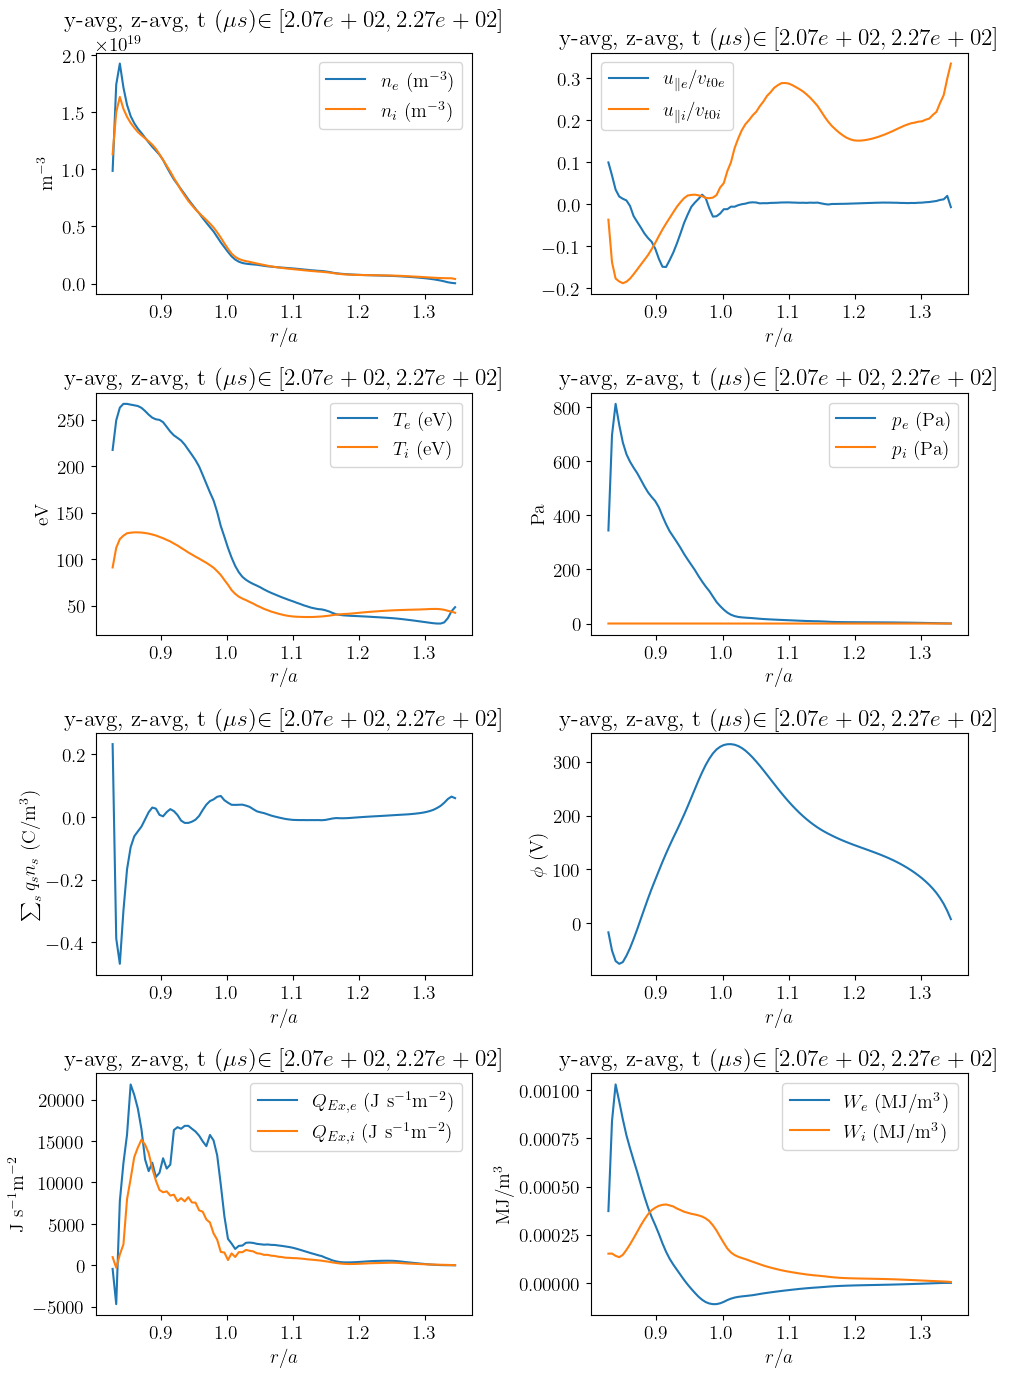

In [17]:
figout = []
cdirection='x'; ccoords=['avg','avg']
pygkyl.plot_utils.plot_1D(
        simulation,cdirection,ccoords,
        fieldnames = [['ne','ni'],['upare','upari'],
                      ['Te','Ti'],['pe','pi'],
                      'qdens','phi',
                      ['ExB_hflux_xe','ExB_hflux_xi'], ['Wtote','Wtoti']
                     ],
        time_frames = sim_frames[-25::5], errorbar = False, figout = figout
        )
pygkyl.fig_tools.save_figout(figout,'fig_profiles') # this allows you to reload and replot with additional data

### 2.9 Volume Integral Quantities <a id="volume_integrals"></a>
Plot volume-integrated quantities such as energies over time.

Processing: Field 1/4, Subfield 3/3, Frame 12/12Total input power: 396.009 kW

Processing: Field 2/4, Subfield 2/2, Frame 12/12
Processing: Field 3/4, Subfield 2/2, Frame 12/12
Processing: Field 4/4, Subfield 2/2, Frame 12/12


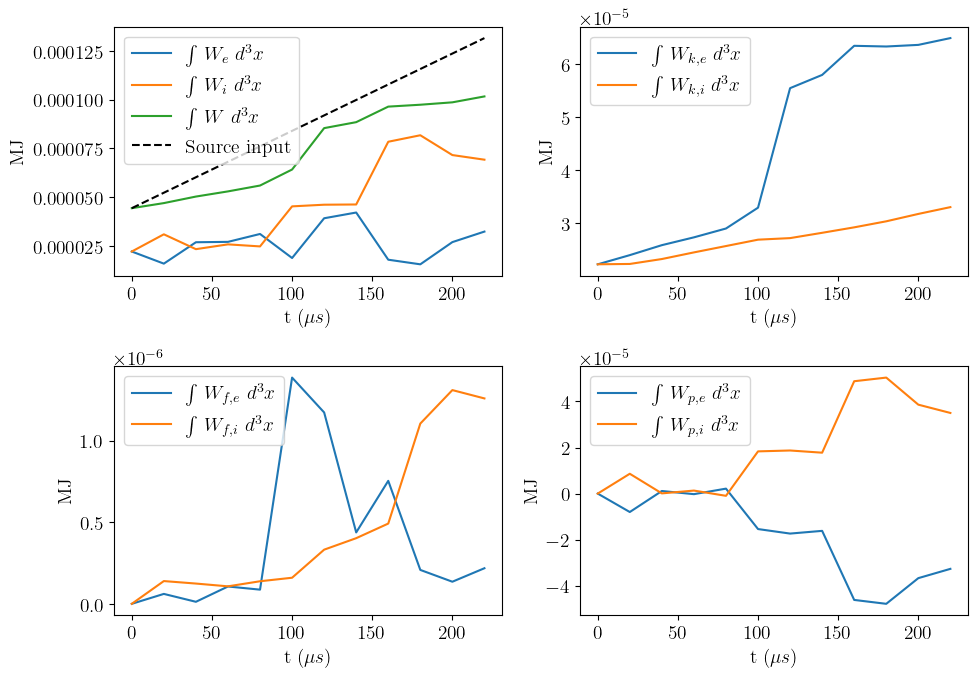

In [18]:
# This format allows to plot different fields on top of eachother
fieldnames = [
    ['Wtote','Wtoti','Wtot'], # total internal energy and per species                 
    ['Wkine','Wkini'], # kinetic energy per species
    ['Wflue','Wflui'], # fluid kinetic energy per species
    ['Wpote','Wpoti'] # potential energy per species
    ]
time_frames = sim_frames[::20] # recommended to avoid computing volume integral for each frames (can be long)
pygkyl.plot_utils.plot_volume_integral_vs_t(
    simulation, fieldnames, time_frames, plot_src_input=True)

### 2.10 Grad B Loss <a id="gradb_loss"></a>
We compute the volume integral of the particle flux, $n v_{\nabla B}$, and energy flux, $n T v_{\nabla B}$, due to the magnetic gradient drift, $v_{\nabla B}$, at the inner radial boundary.
This does not depend on the srcGB parameters

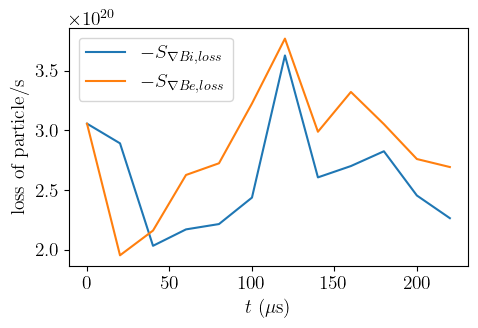

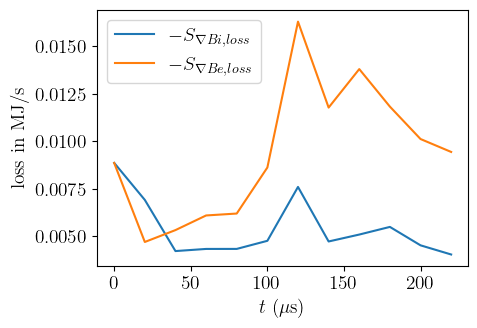

In [19]:
pygkyl.plot_utils.plot_GB_loss(simulation,sim_frames[:-1:20],
                        losstype='particle',integrate=False)
pygkyl.plot_utils.plot_GB_loss(simulation,sim_frames[:-1:20],
                        losstype='energy',integrate=False)

### 2.11 Phase Space Analysis <a id="dist_funct"></a>
This is done manually directly with the pgkyl routines. The distribution function files are usually very slow to load.

In [20]:
#---------- 2D cuts of a frame of the distribution function (long to load)
if False: #set it to true if you have some dist function data
    import postgkyl as pg
    import copy
    # Simulation frame
    tf = sim_frames[-2]
    # Point where each cuts intersect [in Gkeyll units or indices]
    xf = 0.025
    yf = 0.0
    zf = 0.0
    vf = 0.0
    mf = 0.0
    
    for spec in [elc,ion]:
        #---- Load the distf
        fname = simulation.get_filename('f'+spec.nshort,tf)
        data = pg.data.GData(fname)
        dg = pg.data.GInterpModal(data,1,'ms')
        dg.interpolate(0,overwrite=True)

        #---------------- 2D vpar x plots
        cut = copy.copy(data)
        pg.data.select(cut, z1=yf, z2=zf, z4=mf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.vt,
                    title=r"y=%2.2f, z=%2.2f, $\mu$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D mu x plots
        cut = copy.copy(data)
        pg.data.select(cut, z1=yf, z2=zf, z3=vf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"y=%2.2f, z=%2.2f, $v_\parallel$=%2.2f, t=%2.2e (s)"%(yf,zf,mf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$R-R_{lcfs}\,(m)$',ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

        #---------------- 2D vpar mu plots
        cut = copy.copy(data)
        pg.data.select(cut, z0=xf, z1=yf, z2=zf, overwrite=True)
        pg.output.plot(cut, yscale=1./spec.mu0,
                    title=r"x=%2.2f, y=%2.2f, z=%2.2f, t=%2.2e (s)"%(xf,yf,zf,data.ctx['time']),
                    contour=False,diverging=False, xshift=-simulation.geom_param.x_LCFS,
                    xlabel=r'$v_\parallel/v_{th%s}$'%spec.nshort,ylabel=r'$\mu B/T_{%s}$'%spec.nshort,
                    clabel=r'$f_{%s}$'%spec.nshort);

### 2.12 DG representation <a id="dg_rep"></a>
Plot the data in the DG form with cells and segments (1D only)

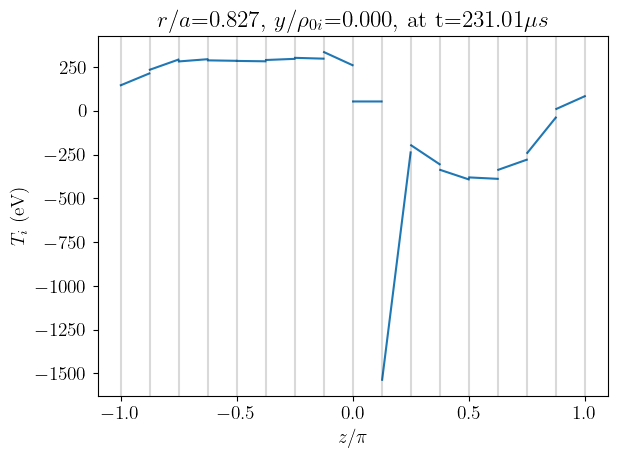

In [21]:
fieldname = 'Ti'
sim_frame = sim_frames[-1]
cutdir = 'z'
cutcoord = [0.0, 0.0]
xlim = []
pygkyl.plot_utils.plot_DG_representation(simulation, fieldname, sim_frame, cutdir, cutcoord, xlim)

### 2.13 Poloidal projection plot <a id="pol_plot"></a>
Project the flux tube on a poloidal plane (play with `nzInterp` to change resolution vs comp. time)

In [8]:
# first we declare a poloidal projection object and set it up (this can take ~30sec for nzInterp=16)
polproj = pygkyl.PoloidalProjection()
polproj.setup(simulation,nzInterp=16)

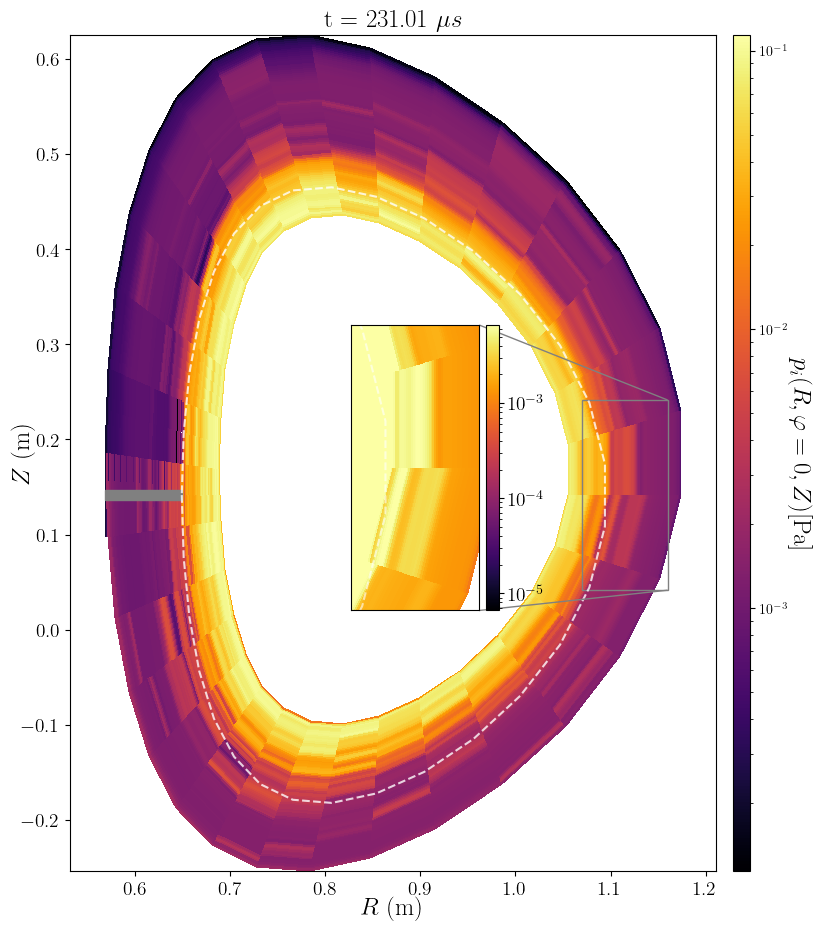

In [9]:
polproj.plot('pi',timeFrame=sim_frames[-1],colorScale='log')

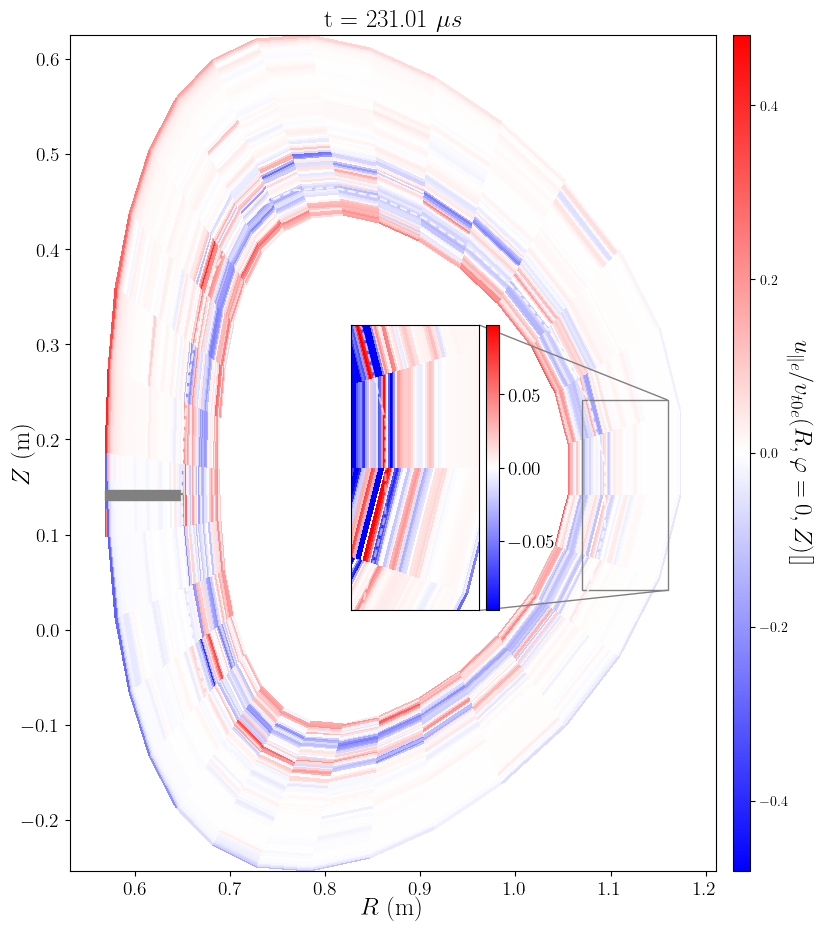

In [10]:
polproj.plot('upare',timeFrame=sim_frames[-1])

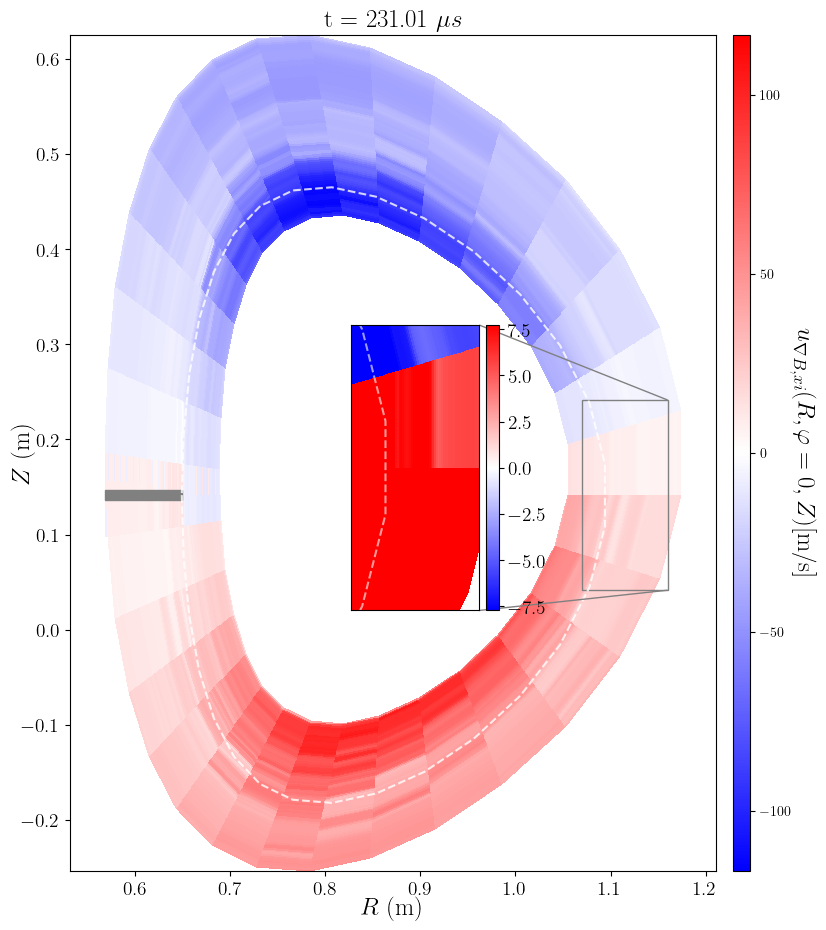

In [11]:
polproj.plot('gradBxB_xi',timeFrame=sim_frames[-1])

You can also create a movie of the poloidal projection by specifying 'RZ' as a cut direction. 
Here we pass the previously defined poloidal projector to spare computational time.
You can also add a number after 'RZ' like 'RZ16' to set the number of interpolating planes you want for the projection. (default is 32)

In [ ]:
polproj.movie('pi',moviePrefix='gallery/mov_example_',timeFrames=sim_frames[-10:],colorScale='log')

Processing frames: 10/10... 
Creating movie gallery/logpi_RZ.gif...
movie gallery/logpi_RZ.gif created.
